# Learn Transitions With Actions

Example of how to train the EI mismatch network to learn the maze transitions previous state and action observation to current state

In [1]:
"""
Created by Flavio Martinelli at 9:32 04/06/2020
"""

import os
import sys
import tfmpl

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import tensorflow as tf
import numpy.random as rd
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime

from maze_tf import Maze2D
from neuron_models_old import SnnLoop
from neuron_models import Lif3fLoop
from utils import average_w_matrix
from sklearn.preprocessing import normalize
from plot_utils import raster_plot, v_plot, draw_matrix_tb, annotate_yrange

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Define network and simulation parameters

In [2]:
maze_size = (4,4)

theta = 0.3169981156555285
# theta = 0.55
eta1 = 0.0009796194970225012
eta2 = 0.015360662582262801

t_steps = 100
epochs = 1500*15-10
# epochs = 3000
out_in_ratio = 2**3
n_actions = 4

seed = 145
tf.random.set_seed(seed)
rd.seed(seed)

### Maze initialization
see [showcase_maze_task.ipynb](showcase_maze_task.ipynb) for more infos

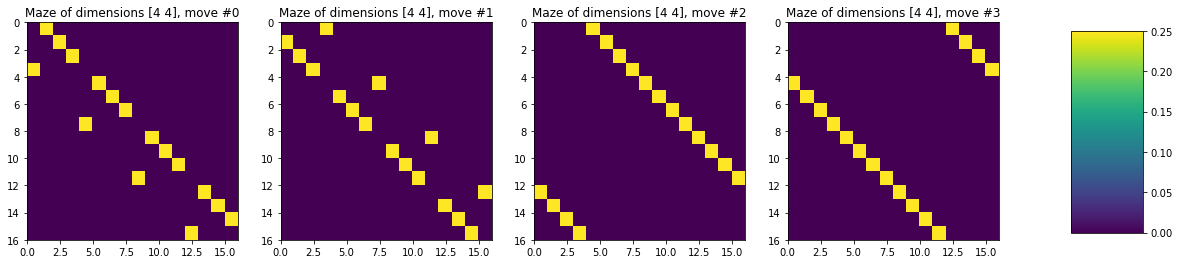

In [3]:
# mz = Maze2D(maze_size, walls=False,proba_opposite=0.05,proba_others=0.05)
mz = Maze2D(maze_size, walls=False,proba_opposite=0.0,proba_others=0.0)
mz.set_spike_train_params(t_steps, high_freq_p=1.0, low_freq_p=0.0)

# Deactivate reward to prevent random repositioning
mz.reward_pos = None

t_mat = mz.build_transition_matrix(separate_actions=True)

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(t_mat):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move #{i}")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)
plt.show()

##### State-action transition matrix 

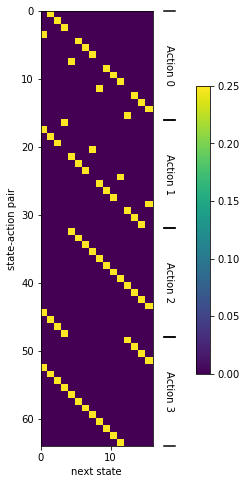

In [4]:
block_t_mat = tf.concat([(tf.constant(mat)) for mat in t_mat], axis=0)
f,ax = plt.subplots(1,1, figsize=(2,8))
im = mz.plot_t_mat(ax, block_t_mat)
for i in range(n_actions):
    annotate_yrange(16*i,16+16*i, f'Action {i}', offset=1.1, width=0.1, ax=ax, text_kwargs={'rotation':-90})
ax.set_xlabel('next state')
ax.set_ylabel('state-action pair')

cax = f.add_axes([1.2, 0.25, 0.1, 0.5])
f.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [5]:
n_obs = mz.tot_room_number
n_wm = mz.tot_room_number*n_actions
n_err = mz.tot_room_number*out_in_ratio

logbase = "goodlogs/"
# logbase = "logs/"

logdir = logbase + "deterministic_transitions_actions" + f"{n_obs}_{n_wm}+{n_err}/" + f"seed{seed}/" + datetime.now().strftime("%m%d-%H%M")
writer = tf.summary.create_file_writer(logdir)
logdir

'goodlogs/deterministic_transitions_actions16_64+128/seed145/0605-1616'

### Weight initialization
The weight matrix combines both populations for ease of computation

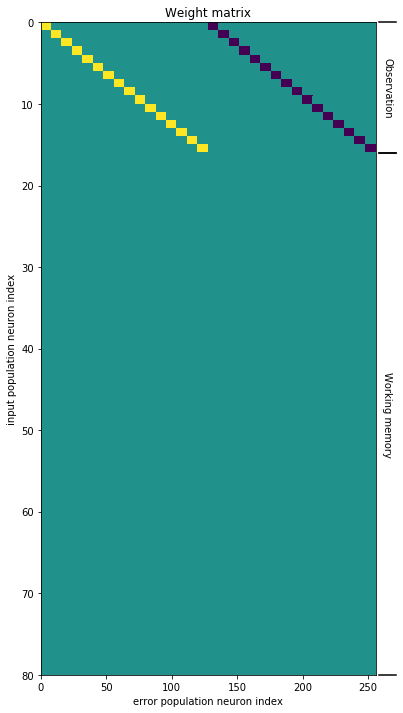

In [6]:
# Initialize network [two input sets of size n_in and two output populations of size n_err]

# Block identity matrix
obs_m1 = (1.0) * np.kron(np.eye(n_obs), np.ones([1, out_in_ratio]))  #martin put them to 1 too

# wm_m1 = rd.uniform(1.5, 2., (n_in, n_pop))
wm_m1 = np.zeros((n_wm, n_err))

full_w_in = np.block([[obs_m1, -obs_m1], [-wm_m1, wm_m1]])

f,ax = plt.subplots(1,1, figsize=(6,12))
mz.plot_t_mat(ax, full_w_in)
ax.set_title('Weight matrix')
ax.set_xlabel('error population neuron index')
ax.set_ylabel('input population neuron index')
annotate_yrange(0,16, f'Observation', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})
annotate_yrange(16,80, f'Working memory', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})

plt.show()

### Network and input initialization 

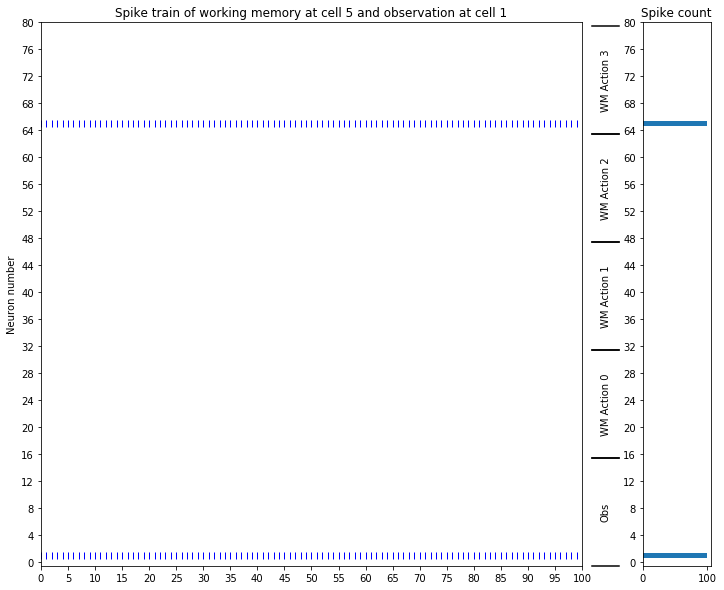

In [7]:
net = Lif3fLoop(n_obs=n_obs, n_wm=n_wm, n_err1=n_err, n_err2=n_err, w_in=full_w_in, eta1=eta1, eta2=eta2, theta=theta, seed=seed)

# create observation and working memory input spike trains and concatenate them together [1, t_steps, n_in * 2]

old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state, action)))
spk_obs = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state)))
inputs = tf.concat([spk_obs, spk_wm], axis=-1)



f, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, inputs, linewidth = 1, color='b')
ax.set_title(f'Spike train of working memory at cell {old_pos} and observation at cell {mz._state}')
ax.set_ylabel("Neuron number")

spk_count = tf.reduce_sum(inputs, axis=0)
ax2.barh(np.arange(n_obs+n_wm), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))
ax.set_yticks(np.floor(np.linspace(0, n_obs+n_wm, 21)))

annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(4):
    annotate_yrange(15.5+i*mz.tot_room_number, 15.5+16+i*mz.tot_room_number, f'WM Action {i}',
                    offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})


plt.show()

### Simulation

In [8]:
a_trace = []
s_trace = []
f_trace = []
t_mat_trace = [t_mat]

rnn_inner_state = None

last_v = None
last_activity = None


@tf.function
def run_step(inp, v, a):
    return net.run(inp, v, a)

In [9]:
for e in tqdm(range(epochs)):
    v, z, activity, surprise = run_step(inputs, last_v, last_activity)

    old_pos = new_pos
    action = rd.randint(4)
    transition = mz._step(action)
    new_pos = transition.observation[0]

    spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, action)))
    spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state))
    inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)

    last_v = v[-1]
    last_activity = activity[-1]

    # switch transition matrix
    if e % 1500 == 0 and e != 0:
        t_mat = mz.shuffle(separe_actions=True)
        block_t_mat = tf.concat([(tf.constant(mat)) for mat in t_mat], axis=0)
        t_mat_trace.append(t_mat)

    # Compute metrics
    a_trace.append(activity)
    s_trace.append(surprise)

    learned_t_mat = average_w_matrix(net.w_in*1.0, out_in_ratio)
    learned_t_mat = normalize(learned_t_mat[-n_wm:, -n_obs:], norm='l1', axis=0)
        
    f_trace.append(np.sum((block_t_mat-learned_t_mat)**2))

    with writer.as_default():
        tf.summary.scalar('frobenius_norm_transition_error', f_trace[-1], step=e)
        tf.summary.scalar('average_surprise', tf.reduce_mean(s_trace[-1]), step=e)
        tf.summary.scalar('average_activity', tf.reduce_mean(a_trace[-1]) / net.A0, step=e)

        if e % 20 == 0:
            tf.summary.image('learnt_transition_matrix', draw_matrix_tb(learned_t_mat, figsize=(5,8)), step=e)
            if e % 1500 == 0:
                tf.summary.image('true_transition_matrix', draw_matrix_tb(block_t_mat, figsize=(5,8)), step=e)

  0%|                                                                                        | 0/22490 [00:00<?, ?it/s]

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


100%|████████████████████████████████████████████████████████████████████████████| 22490/22490 [14:41<00:00, 25.52it/s]


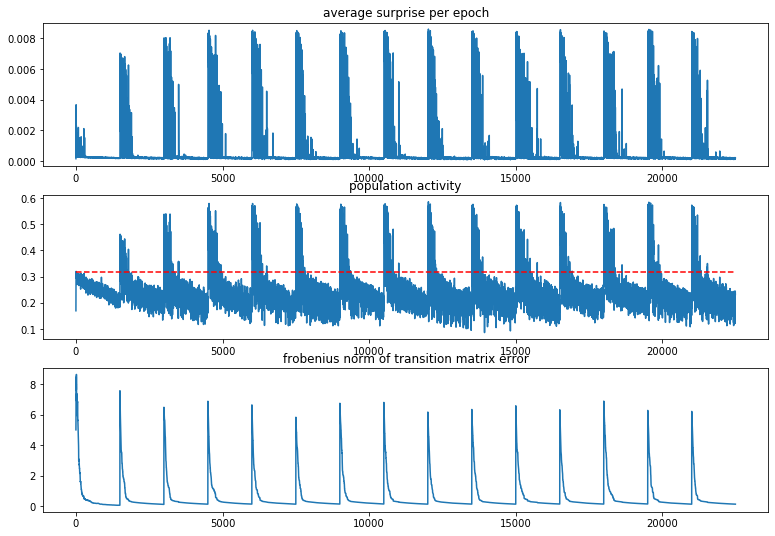

In [10]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,9))
ax1.plot(tf.reduce_mean(s_trace, axis=1))
ax1.set_title('average surprise per epoch')

ax2.plot(np.array(tf.reduce_mean(tf.stack(a_trace), axis=1) / net.A0))
ax2.set_title('population activity')
ax2.hlines(theta, 0, epochs, 'r','--', zorder=3)

ax3.plot(np.array(f_trace))
ax3.set_title('frobenius norm of transition matrix error')
plt.show()


We see a very different activity profie with respect to either the fully deterministic case of state-action or the fully stochastic case of exploration. This is due to the nature of the network to increase its activity when seeing unexpected events such as low probability stochastic actions. More in details explanation below

## Simulate step by step and view of error population

- We can see that error population 1 (which receives excitation from the observation population and inhibition from the working memory) correctly reflect the signal of the observation. Note that when the observation state is not the one the action was predicting, the activity of the error population 1 is much higher (around 20 spikes instead of 10, still at the observed state)

- Error population 2 instead is activated in the three other states the transition could occur (accounting for the slight stochasticity of the action). Note that when a stochastic transition occurs, the supposed next state dictated from the action fires a lot since it is not inhibited (around 20 spikes instead of 0)

In [11]:
act_str = ['right', 'left', 'down', 'up']

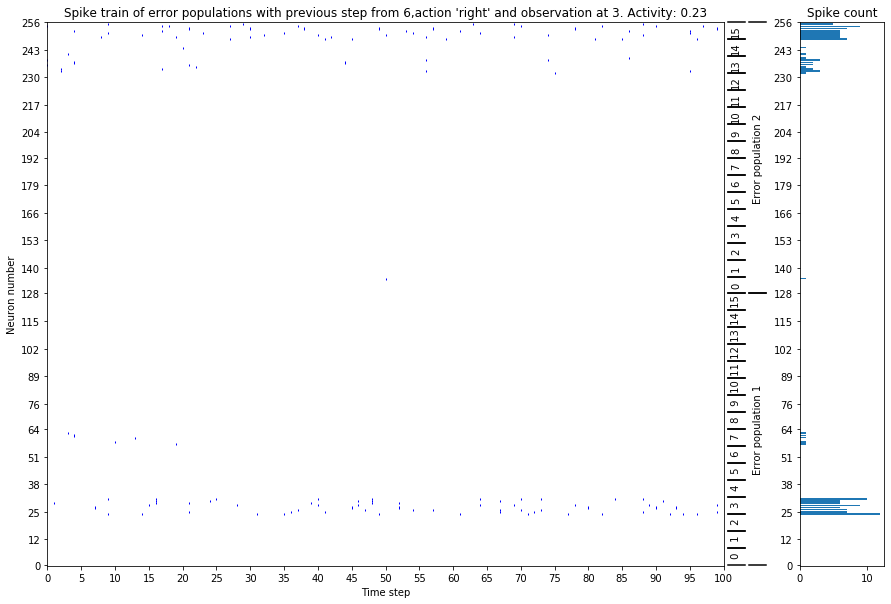

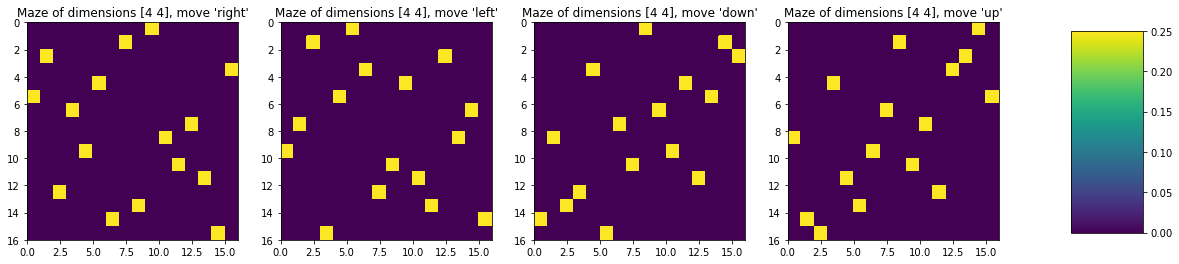

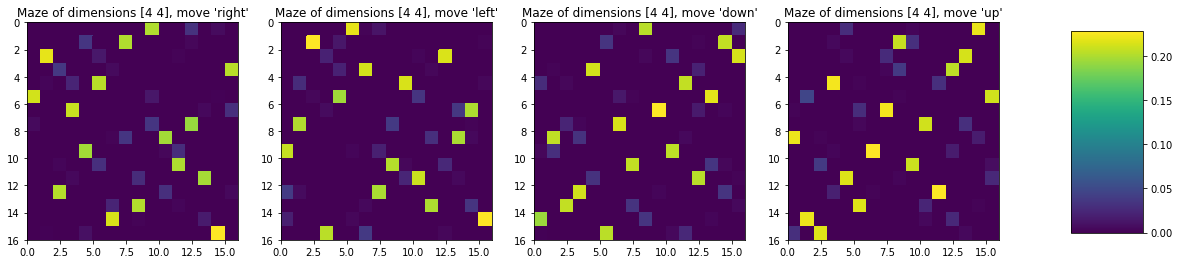

In [12]:
old_pos = mz._state
action = rd.randint(4)
transition = mz._step(action)
new_pos = transition.observation[0]

spk_wm = tf.squeeze(Maze2D.spk_train_to_tensor(mz.generate_spike_train(old_pos, action)))
spk_obs = Maze2D.spk_train_to_tensor(mz.generate_spike_train(mz._state))
inputs = tf.concat([tf.squeeze(spk_obs), tf.squeeze(spk_wm)], axis=-1)

v, z, activity, surprise = run_step(inputs, last_v, last_activity)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [8, 1]})

raster_plot(ax, z, linewidth = 1, color='b')
ax.set_title(f"Spike train of error populations with previous step from {old_pos},\
action '{act_str[action]}' and observation at {new_pos}. Activity: {np.mean(activity/net.A0):.2f}")
ax.set_ylabel("Neuron number")
ax.set_xlabel("Time step")

spk_count = tf.reduce_sum(z, axis=0)
ax2.barh(np.arange(z.shape[1]), spk_count)
ax2.set_title("Spike count")
# ax2.axes.get_yaxis().set_visible(False)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))
ax.set_yticks(np.floor(np.linspace(0, z.shape[1], 21)))

# annotate_yrange(-.5, 15.5, f'Obs', offset=-0.75, width=0.4, ax=ax2, text_kwargs={'rotation':90})

for i in range(mz.tot_room_number):
    annotate_yrange(i*out_in_ratio, (i+1)*out_in_ratio, f' {i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})
    annotate_yrange((i+mz.tot_room_number)*out_in_ratio, (i+1+mz.tot_room_number)*out_in_ratio, f'{i}',
                    offset=-0.85, width=0.2, ax=ax2, text_kwargs={'rotation':90})

annotate_yrange(0, mz.tot_room_number*out_in_ratio, f'Error population 1',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})
annotate_yrange(mz.tot_room_number*out_in_ratio, 2*mz.tot_room_number*out_in_ratio, f'Error population 2',
                offset=-0.60, width=0.2, ax=ax2, text_kwargs={'rotation':90})

# Plot transitions to help understand the actions

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(t_mat_trace[-1]):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)


fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i,mat in enumerate(learned_t_mat[-n_wm:, -n_obs:].reshape(n_actions, mz.tot_room_number, mz.tot_room_number)):
    pcol = mz.plot_t_mat(ax[i], t_mat=mat)
#     pcol.set_clim(0.0,0.5)
    ax[i].set_title(f"Maze of dimensions {mz.size}, " + f"move '{act_str[i]}'")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pcol, cax=cbar_ax)


plt.show()


## Final weight matrix

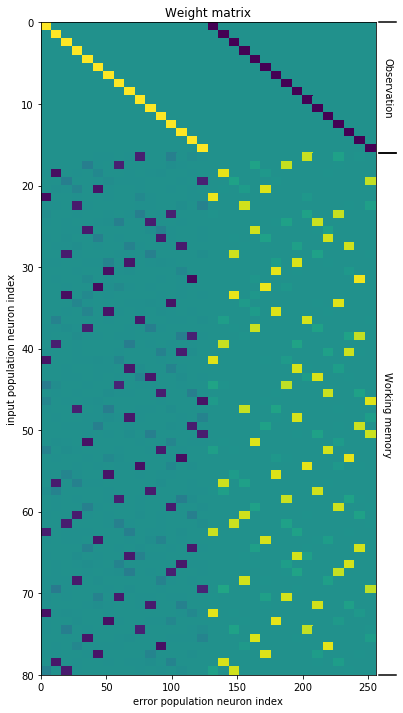

In [13]:
f,ax = plt.subplots(1,1, figsize=(6,12))
mz.plot_t_mat(ax, net.w_in.numpy())
ax.set_title('Weight matrix')
ax.set_xlabel('error population neuron index')
ax.set_ylabel('input population neuron index')
annotate_yrange(0,16, f'Observation', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})
annotate_yrange(16,80, f'Working memory', offset=1.01, width=0.05, ax=ax, text_kwargs={'rotation':-90})

plt.show()